In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install prophet
from prophet import Prophet
#import statsmodels as sm
import statsmodels.api as sm
import datetime as dt
import math
from pandas.plotting import autocorrelation_plot
!pip install pmdarima
import pmdarima as pmd
import os 
import sklearn
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

## Data and Data PreProcessing

In [2]:
# Importing Craftbeer data from exel file
df = pd.read_excel("order,time series.xlsx")


In [3]:
df.head()

,OrderType,OrderCategory,CustomerCode,CountryName,CustomerOrderNo,Custorderdate,UnitName,QtyRequired,TotalArea,Amount,ITEM_NAME,QualityName,DesignName,ColorName,ShapeName,AreaFt
0,Area Wise,Order,H-1,USA,1873354,2017-01-16,Ft,2,6.00,12.00,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],BEIGE,REC,6.00
1,Area Wise,Order,H-1,USA,1873354,2017-01-16,Ft,2,9.00,18.00,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],BEIGE,REC,9.00
2,Area Wise,Order,H-1,USA,1873354,2017-01-16,Ft,2,54.00,108.00,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],BEIGE,REC,54.00
3,Area Wise,Order,H-1,USA,1873354,2017-01-16,Ft,5,71.25,356.25,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],BEIGE,REC,71.25
4,Area Wise,Order,H-1,USA,1873354,2017-01-16,Ft,6,128.25,769.50,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],GREEN/IVORY,REC,128.25


In [17]:
import pandas as pd


# Specify the columns to keep ('Date', 'Amount', 'CustomerCode')

df.rename(columns={'Custorderdate': 'Date'}, inplace=True)
columns_to_keep = ['Date', 'Amount']
df1 = df[columns_to_keep]


print(df1.head())


df1.shape

        Date  Amount
0 2017-01-16   12.00
1 2017-01-16   18.00
2 2017-01-16  108.00
3 2017-01-16  356.25
4 2017-01-16  769.50


(13135, 2)

In [19]:
import pandas as pd


# Convert 'Custorderdate' column to datetime format
df1['Date'] = pd.to_datetime(df1['Date'])

# Group by 'Custorderdate' and sum the 'Amount' for each date
df1 = df.groupby('Date')['Amount'].sum().reset_index()




In [20]:
print(df1.head())


df1.shape

        Date      Amount
0 2017-01-16   8780.6250
1 2017-01-17   9982.7500
2 2017-01-21    102.5000
3 2017-02-01  12666.4375
4 2017-02-02      9.5000


(620, 2)

In [21]:
df1.dtypes

Date      datetime64[ns]
Amount           float64
dtype: object

In [22]:
df1.isnull().sum()

Date      0
Amount    0
dtype: int64

No missing values

In [23]:
df1.nunique()

Date      620
Amount    573
dtype: int64

Now, we should change fromat of columns from objects to DateTime

Combination of date in one column and changing the name of them to ds and y

In [76]:
df1= df1.rename(columns={'Date': 'ds','Amount': 'y',})

df1 = df1[['ds', 'y']]
df1.head()

,ds,y
0,2017-01-16,8780.6250
1,2017-01-17,9982.7500
2,2017-01-21,102.5000
3,2017-02-01,12666.4375
4,2017-02-02,9.5000


In [151]:
import pandas as pd


# Find the index of the outlier (for example, the maximum value in 'y')
outlier_index = df1['y'].idxmax()


outlier_indices = df1['y'].nlargest(3).index

# Drop the rows corresponding to the outlier indices
df1_train = df1.drop(outlier_indices)


# Now the maximum 'y' value has been replaced by the calculated average
print(df1)


            ds            y
0   2017-01-16    8780.6250
1   2017-01-17    9982.7500
2   2017-01-21     102.5000
3   2017-02-01   12666.4375
4   2017-02-02       9.5000
..         ...          ...
615 2020-02-08  131229.1000
616 2020-02-11     389.0250
617 2020-02-12  157779.4000
618 2020-02-13     659.0000
619 2020-02-14     737.1000

[620 rows x 2 columns]


## Train_Test Data

In [152]:

# Define test set based on the specified date range
#df1_test = df1[(df1['ds'] >= dt.datetime(2017, 1, 1))]
#df1_test = df1_test.reset_index(drop=True)

# Define train set based on the specified date range
#df1_train = df1[(df1['ds'] < dt.datetime(2020, 3, 1))]
#df1_train = df1_train.reset_index(drop=True)


In [153]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with a time series column ('ds') and target column ('y')

# Sort the DataFrame by the time series column
df1_sorted = df1.sort_values('ds')

# Define the percentage split for the train and test sets
train_percentage = 0.8  # For example, 80% for training data

# Calculate the index to split the data into train and test sets
split_index = int(train_percentage * len(df1_sorted))

# Split the data into train and test sets based on the calculated index
train_data = df1_sorted.iloc[:split_index]
test_data = df1_sorted.iloc[split_index:]

# Optional: Convert train and test sets back to their original order (if needed)
train_data = train_data.sort_index()
test_data = test_data.sort_index()

# Print the lengths of the train and test sets to verify
print("Train set length:", len(train_data))
print("Test set length:", len(test_data))


Train set length: 496
Test set length: 124


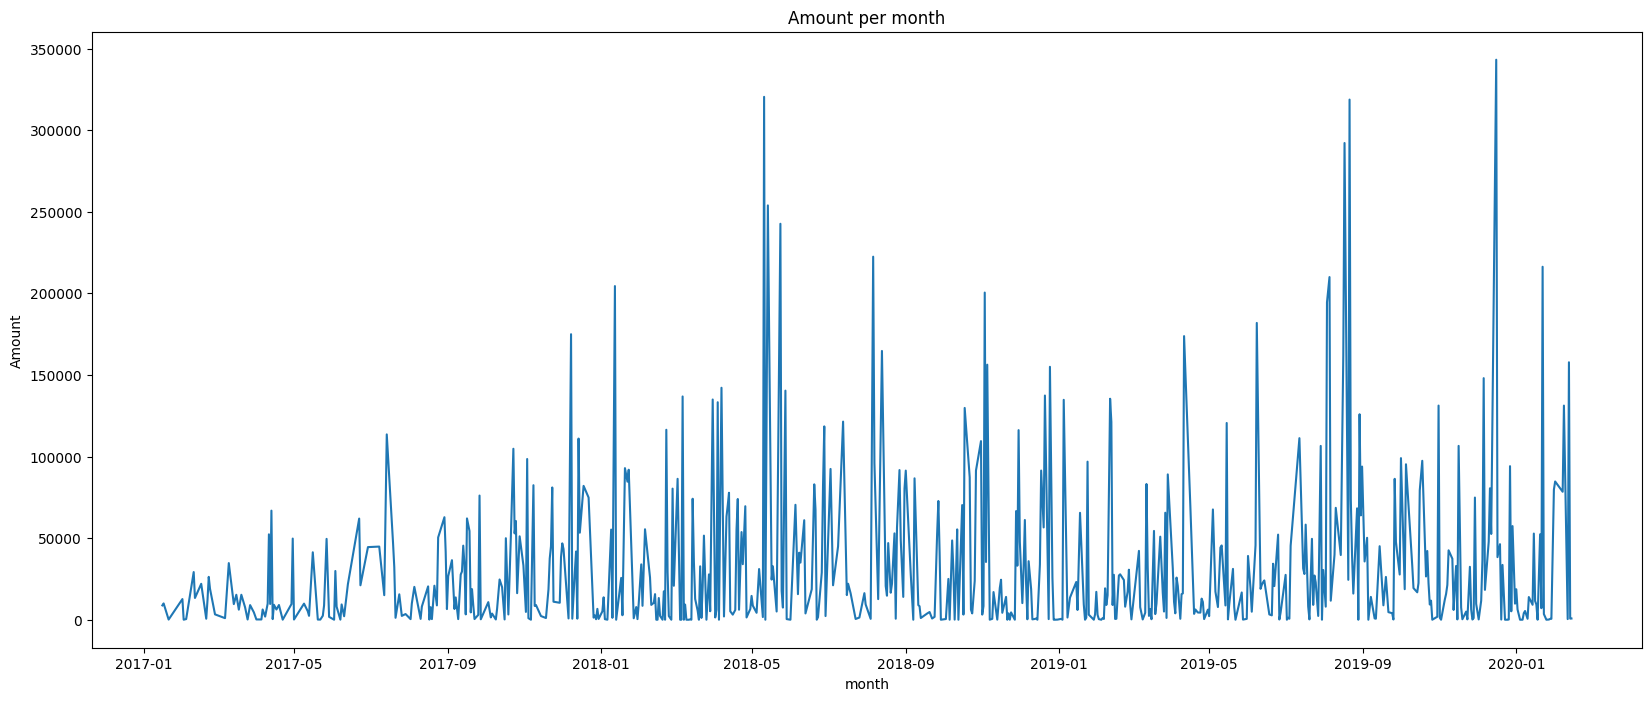

In [154]:
plt.figure(figsize=(20,8))
plt.plot(df1_train['ds'], df1_train['y'])
plt.xlabel('month')
plt.ylabel('Amount')
plt.title('Amount per month')
plt.show()

Text(0.5, 1.0, 'Autocorrelation Plot')

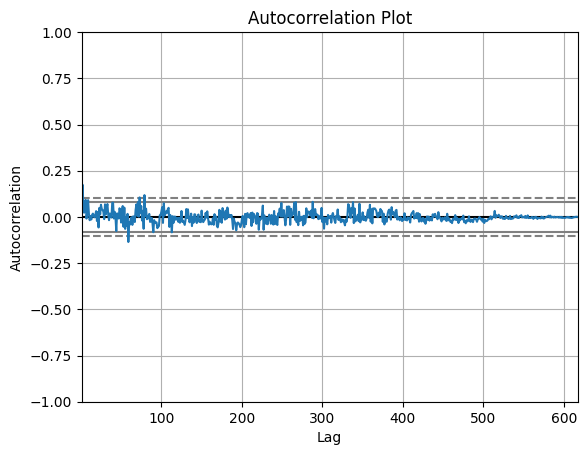

In [156]:
from pandas.plotting import autocorrelation_plot
data = np.array(df1_train['y'])
autocorrelation_plot(data)
plt.title('Autocorrelation Plot')

### Baseline Methods

In [157]:
pred = pd.DataFrame(df1_test['ds'])
pred = pred.reset_index(drop = True)
h_max =12 
yT = df1_train['y'][len(df1_train) - 1]
y1 = df1_train['y'][0]
T = len(df1_train)
m = 12

### Mean Baseline

In [158]:
# Mean baseline
pred['mean_baseline'] = df1_train['y'].mean()

## Naive Baseline

In [159]:
# Naive Baseline
pred['naive_baseline'] = yT

## Seasonal Naive Baseline

In [160]:
import math

# Assuming 'h_max' is appropriately determined for your task

# Calculate the Seasonal Naive Baseline
pred_list = []
for h in range(1, h_max + 1): 
    k = math.floor((h - 1) / m)
    index = T + h - m * (k + 1)
    if index <= len(df1_train):
        pred_list.append(df1_train['y'][index - 1])
    else:
        # Handle the case when the index is out of range
        remainder = len(df1_train) % m
        if remainder != 0:
            pred_list.append(df1_train['y'][remainder - 1])
        else:
            pred_list.append(df1_train['y'][m - 1])

# Ensure the lengths match before assigning to the DataFrame
if len(pred_list) < len(pred):
    pred_list.extend([None] * (len(pred) - len(pred_list)))
elif len(pred_list) > len(pred):
    pred_list = pred_list[:len(pred)]

# Assign the values to the 'seasonal_naive_baseline' column in pred DataFrame
pred['seasonal_naive_baseline'] = pred_list  # Assigning the values

# Display or use the 'pred' DataFrame
print(pred)


            ds  mean_baseline  naive_baseline  seasonal_naive_baseline
0   2017-01-16   32474.388115         389.025                  7071.50
1   2017-01-17   32474.388115         389.025                216316.95
2   2017-01-21   32474.388115         389.025                  3481.50
3   2017-02-01   32474.388115         389.025                     0.00
4   2017-02-02   32474.388115         389.025                   112.72
..         ...            ...             ...                      ...
615 2020-02-08   32474.388115         389.025                      NaN
616 2020-02-11   32474.388115         389.025                      NaN
617 2020-02-12   32474.388115         389.025                      NaN
618 2020-02-13   32474.388115         389.025                      NaN
619 2020-02-14   32474.388115         389.025                      NaN

[620 rows x 4 columns]


## Drift Baseline

In [161]:
drift_list = []
for h in range(1, h_max + 1):
    result = yT + h * ((yT - y1) / (T - 1))  # Corrected parenthesis
    drift_list.append(result)

# Ensure the lengths match before assigning to the DataFrame
if len(drift_list) < len(pred):
    drift_list.extend([None] * (len(pred) - len(drift_list)))
elif len(drift_list) > len(pred):
    drift_list = drift_list[:len(pred)]

pred['drift_baseline'] = drift_list  # Assigning the values

# Display or use the 'pred' DataFrame
print(pred)



            ds  mean_baseline  naive_baseline  seasonal_naive_baseline  \
0   2017-01-16   32474.388115         389.025                  7071.50   
1   2017-01-17   32474.388115         389.025                216316.95   
2   2017-01-21   32474.388115         389.025                  3481.50   
3   2017-02-01   32474.388115         389.025                     0.00   
4   2017-02-02   32474.388115         389.025                   112.72   
..         ...            ...             ...                      ...   
615 2020-02-08   32474.388115         389.025                      NaN   
616 2020-02-11   32474.388115         389.025                      NaN   
617 2020-02-12   32474.388115         389.025                      NaN   
618 2020-02-13   32474.388115         389.025                      NaN   
619 2020-02-14   32474.388115         389.025                      NaN   

     drift_baseline  
0        375.402273  
1        361.779545  
2        348.156818  
3        334.534091  
4

## Baseline Methods Plots

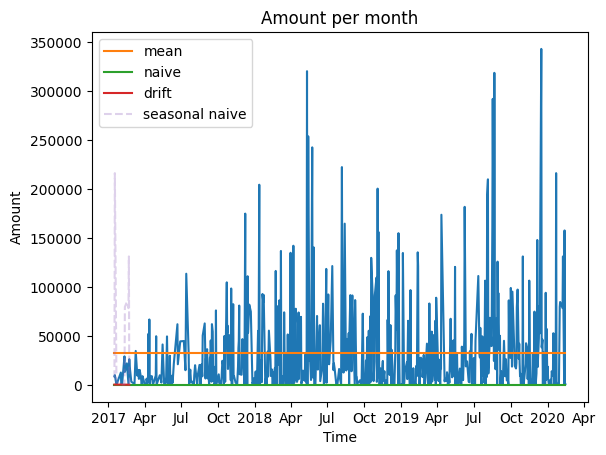

In [162]:
import matplotlib.dates as mdates
locator = mdates.AutoDateLocator(minticks = 10, maxticks = 15)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator) 
plt.gca().xaxis.set_major_formatter(formatter)


plt.plot(df1_train['ds'], df1_train['y'])
## Your plotting code here to add the baseline methods
plt.plot(pred['ds'], pred['mean_baseline'], label = 'mean')
plt.plot(pred['ds'], pred['naive_baseline'], label = 'naive')
plt.plot(pred['ds'], pred['drift_baseline'], label = 'drift')
plt.plot(pred['ds'], pred['seasonal_naive_baseline'], label = 'seasonal naive', linestyle = '--', alpha = 0.3)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Amount per month')
plt.legend()
plt.show()

## Prophet

In [163]:

m = Prophet()
m.fit(df1_train)

10:40:20 - cmdstanpy - INFO - Chain [1] start processing
10:40:20 - cmdstanpy - INFO - Chain [1] done processing


In [164]:
future = m.make_future_dataframe(periods =12, freq ="MS",include_history=False )
future

,ds
0,2020-03-01
1,2020-04-01
2,2020-05-01
3,2020-06-01
4,2020-07-01
5,2020-08-01
6,2020-09-01
7,2020-10-01
8,2020-11-01
9,2020-12-01


In [165]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(12)


,ds,yhat,yhat_lower,yhat_upper
0,2020-03-01,54244.235267,-6075.652125,110392.097017
1,2020-04-01,43325.256327,-15888.129684,97486.514775
2,2020-05-01,39158.499748,-21363.763078,99343.601971
3,2020-06-01,43246.509935,-15076.953643,96472.965326
4,2020-07-01,50384.971580,-9251.626068,113514.447501
5,2020-08-01,53411.991771,-4360.119771,113553.924835
6,2020-09-01,42927.856789,-12684.460407,103773.357024
7,2020-10-01,36210.631301,-21555.426468,95876.616923
8,2020-11-01,71836.201453,12140.033484,127340.257748
9,2020-12-01,40440.772160,-16713.146198,99366.892973


In [166]:
pred['Prophet']=forecast['yhat'].reset_index(drop=True)
pred

,ds,mean_baseline,naive_baseline,seasonal_naive_baseline,drift_baseline,Prophet
0,2017-01-16,32474.388115,389.025,7071.50,375.402273,54244.235267
1,2017-01-17,32474.388115,389.025,216316.95,361.779545,43325.256327
2,2017-01-21,32474.388115,389.025,3481.50,348.156818,39158.499748
3,2017-02-01,32474.388115,389.025,0.00,334.534091,43246.509935
4,2017-02-02,32474.388115,389.025,112.72,320.911364,50384.971580
...,...,...,...,...,...,...
615,2020-02-08,32474.388115,389.025,NaN,NaN,NaN
616,2020-02-11,32474.388115,389.025,NaN,NaN,NaN
617,2020-02-12,32474.388115,389.025,NaN,NaN,NaN
618,2020-02-13,32474.388115,389.025,NaN,NaN,NaN


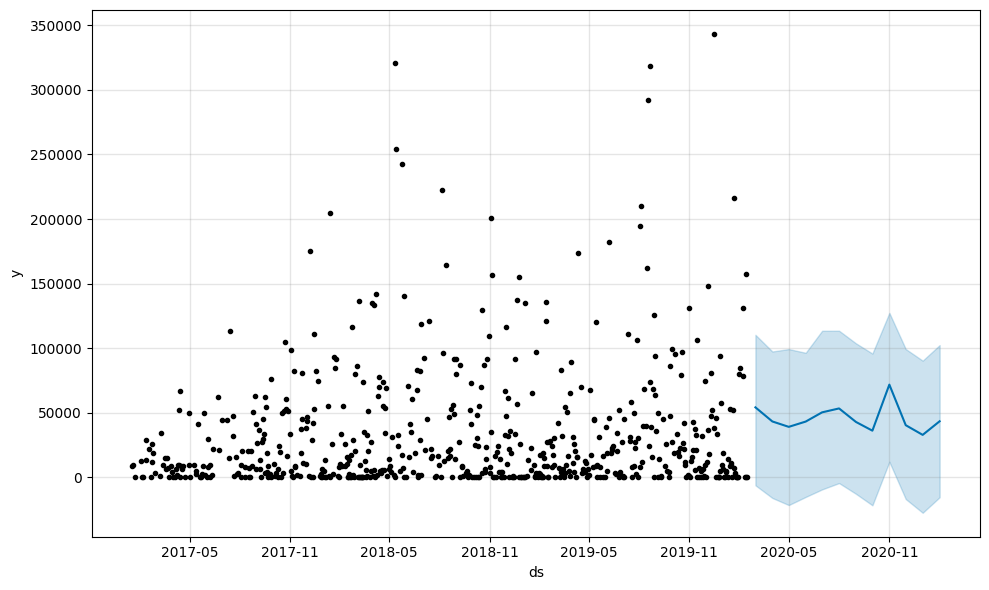

In [167]:
fig1 = m.plot(forecast)


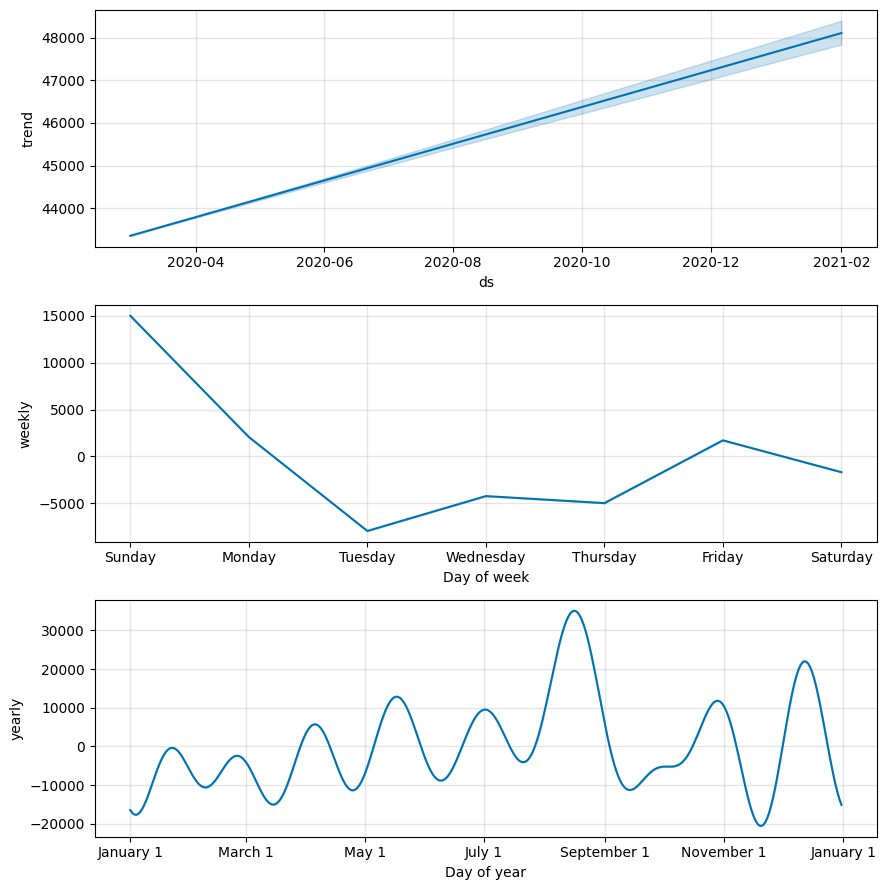

In [168]:
fig2 = m.plot_components(forecast)


## ARIMA

In [239]:
import pmdarima as pmd
m = 310
seasonal = True
autoarima_model = pmd.auto_arima(df1_train['y'], seasonal = True, m = m, trace = True, method='nm')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[310] intercept   : AIC=15033.228, Time=127.19 sec
 ARIMA(0,1,0)(0,0,0)[310] intercept   : AIC=15433.021, Time=0.27 sec
 ARIMA(1,1,0)(1,0,0)[310] intercept   : AIC=15192.474, Time=117.52 sec


MemoryError: Unable to allocate 462. MiB for an array with shape (313, 313, 618) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 982, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 462. MiB for an array with shape (313, 313, 618) and data type float64


AttributeError: Memoryview is not initialized

In [233]:
import pmdarima as pmd

# Reduced seasonal frequency (adjust the value as needed)
m = 310 # For instance, reducing from 12 to 6

# Fit the auto_arima model with reduced seasonality
autoarima_model = pmd.auto_arima(
    df1_train['y'],
    seasonal=True,
    m=m,
    trace=True,
    method='nm'
)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[20] intercept   : AIC=15034.150, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[20] intercept   : AIC=15433.021, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[20] intercept   : AIC=15192.521, Time=0.89 sec
 ARIMA(0,1,1)(0,0,1)[20] intercept   : AIC=15026.588, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[20]             : AIC=15431.021, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[20] intercept   : AIC=15025.685, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[20] intercept   : AIC=15026.583, Time=0.81 sec
 ARIMA(0,1,1)(1,0,1)[20] intercept   : AIC=15028.188, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[20] intercept   : AIC=15032.268, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[20] intercept   : AIC=15028.525, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[20] intercept   : AIC=15190.656, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[20] intercept   : AIC=15030.032, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[20]             : AIC=15024.211, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[20]             : AIC=15024.643, Time=0.81 sec
 ARIM

In [234]:
print(autoarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  617
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -7510.105
Date:                Tue, 05 Dec 2023   AIC                          15024.211
Time:                        11:20:07   BIC                          15033.057
Sample:                             0   HQIC                         15027.650
                                - 617                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9689      0.008   -121.907      0.000      -0.985      -0.953
sigma2      2.268e+09   4.29e-13   5.28e+21      0.000    2.27e+09    2.27e+09
Ljung-Box (L1) (Q):                   0.03   Jarque-

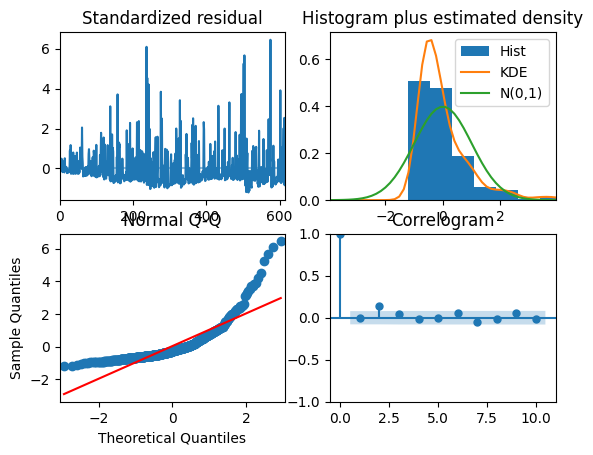

In [235]:

fig = autoarima_model.plot_diagnostics()

In [236]:
pred['autoarima']=autoarima_model.predict(20).reset_index(drop=True)
pred['autoarima']

0      38305.118004
1      38305.118004
2      38305.118004
3      38305.118004
4      38305.118004
           ...     
615             NaN
616             NaN
617             NaN
618             NaN
619             NaN
Name: autoarima, Length: 620, dtype: float64

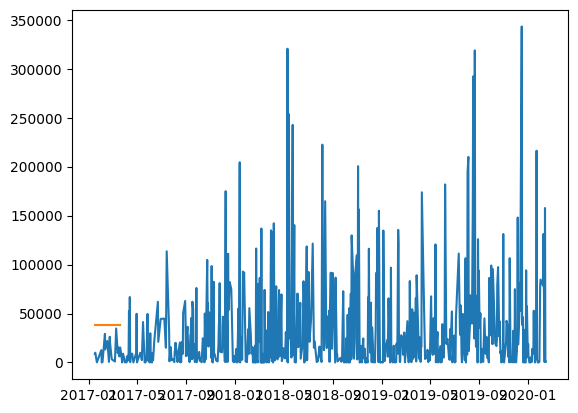

In [237]:
plt.plot(df1_train['ds'], df1_train['y'])
plt.plot(df1_test['ds'], pred['autoarima'])

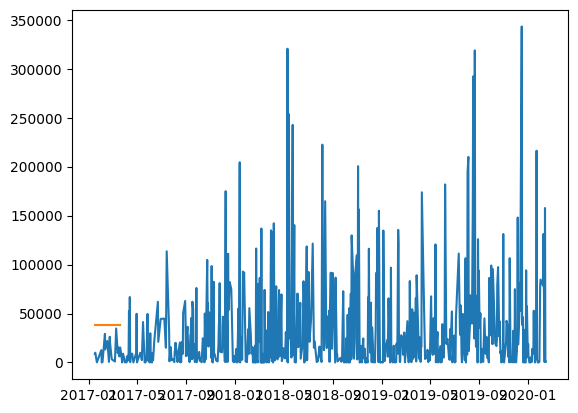

In [238]:
import matplotlib.pyplot as plt

# Plotting the training data
plt.plot(df1_train['ds'], df1_train['y'])

# Plotting the predicted values on the test data using AutoARIMA
plt.plot(df1_test['ds'], pred['autoarima'])

# Display the plot
plt.show()


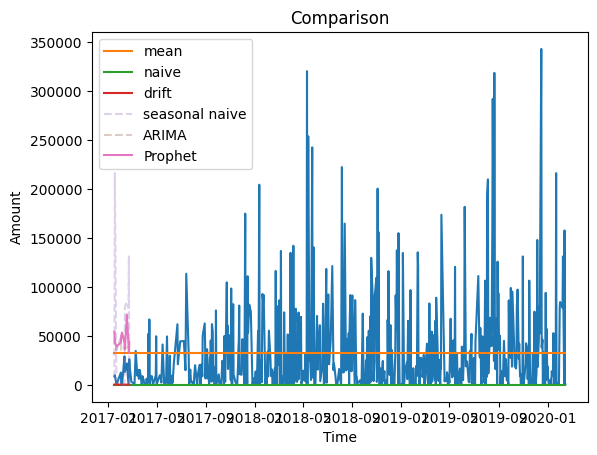

In [175]:

plt.plot(df1_train['ds'], df1_train['y'])
plt.plot(pred['ds'], pred['mean_baseline'], label = 'mean')
plt.plot(pred['ds'], pred['naive_baseline'], label = 'naive')
plt.plot(pred['ds'], pred['drift_baseline'], label = 'drift')
plt.plot(pred['ds'], pred['seasonal_naive_baseline'], label = 'seasonal naive', linestyle = '--', alpha = 0.3)
plt.plot(pred['ds'], pred['autoarima'], label = 'ARIMA', linestyle = '--', alpha = 0.3)
plt.plot(pred['ds'], pred['Prophet'], label = 'Prophet')
#plt.plot(pred['ds'], pred['regression'], label = 'regression')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Comparison')
plt.legend()
plt.show()


In [226]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming 'pred' and 'df1_test' are DataFrames with a common column 'ds'

# Merge the DataFrames based on the 'ds' column
merged_data = pd.merge(pred, df1_test, on='ds', how='inner')

# Drop rows containing NaN values in the columns used for MSE calculation
merged_data_clean = merged_data.dropna(subset=['mean_baseline', 'naive_baseline', 'seasonal_naive_baseline', 'drift_baseline', 'autoarima', 'Prophet', 'y'])

# Calculate MSE for relevant columns of different models after dropping NaN values
print('Mean baseline MSE: ', mean_squared_error(merged_data_clean['mean_baseline'], merged_data_clean['y']))
print('Naive baseline MSE: ', mean_squared_error(merged_data_clean['naive_baseline'], merged_data_clean['y']))
print('Seasonal naive baseline MSE : ', mean_squared_error(merged_data_clean['seasonal_naive_baseline'], merged_data_clean['y']))
print('Drift baseline MSE: ', mean_squared_error(merged_data_clean['drift_baseline'], merged_data_clean['y']))
print('Auto Arima Model MSE:', mean_squared_error(merged_data_clean['autoarima'], merged_data_clean['y']))
print('Prophet Model MSE:', mean_squared_error(merged_data_clean['Prophet'], merged_data_clean['y']))
# Add other models in a similar manner



Mean baseline MSE:  546121521.2793223
Naive baseline MSE:  215082799.67359272
Seasonal naive baseline MSE :  6072979563.440098
Drift baseline MSE:  217393431.58410922
Auto Arima Model MSE: 883218594.994877
Prophet Model MSE: 1375473328.2998636


## SARIMAX

In [177]:

df2 = pd.read_excel("order,time series.xlsx")



In [182]:
import pandas as pd
df.rename(columns={'Custorderdate': 'Date'}, inplace=True)
columns_to_keep = ['Date', 'Amount']
df2 = df[columns_to_keep]

# Convert 'Custorderdate' column to datetime format
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Custorderdate' and sum the 'Amount' for each date
df2 = df.groupby('Date')['Amount'].sum().reset_index()
df2= df2.rename(columns={'Date': 'ds','Amount': 'y',})

df2 = df2[['ds', 'y']]

# Find the index of the outlier (for example, the maximum value in 'y')
outlier_index = df2['y'].idxmax()


outlier_indices = df2['y'].nlargest(3).index

# Drop the rows corresponding to the outlier indices
df2 = df2.drop(outlier_indices)



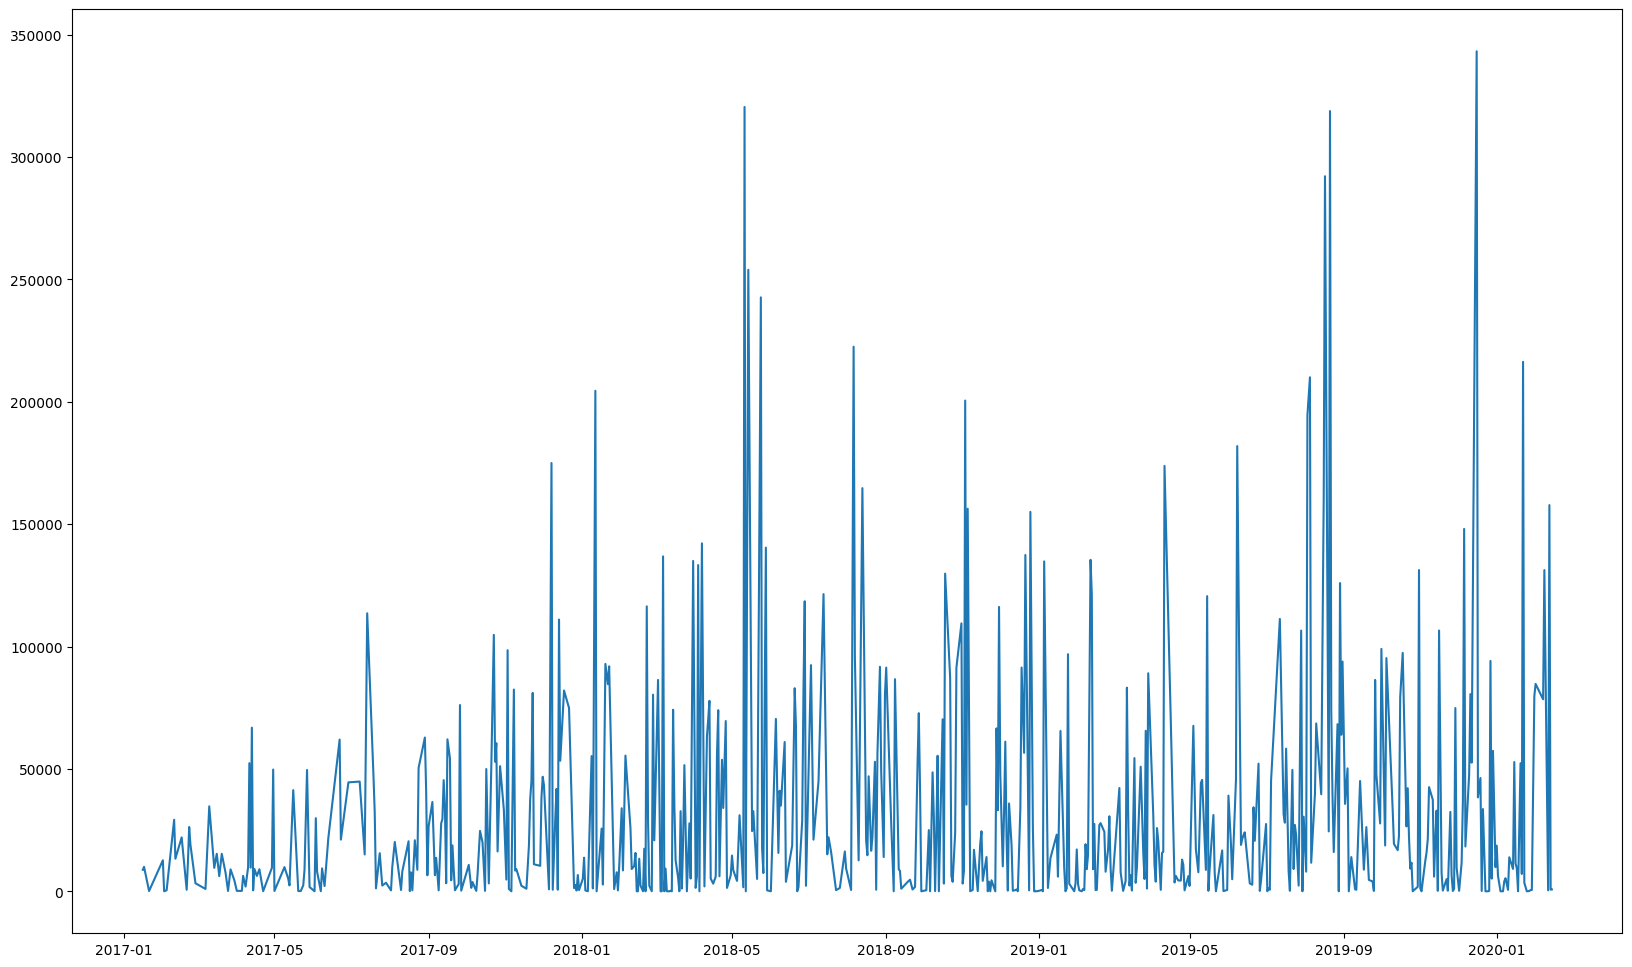

In [183]:
plt.figure(figsize=(20, 12))
plt.plot(df2['ds'], df2['y'])
plt.show()

In [184]:
adfuller(df2['y']) 

(-11.611103901020423,
 2.511958671047333e-21,
 2,
 614,
 {'1%': -3.4410451945636207,
  '5%': -2.8662587328558566,
  '10%': -2.569282988466721},
 14563.047477429312)

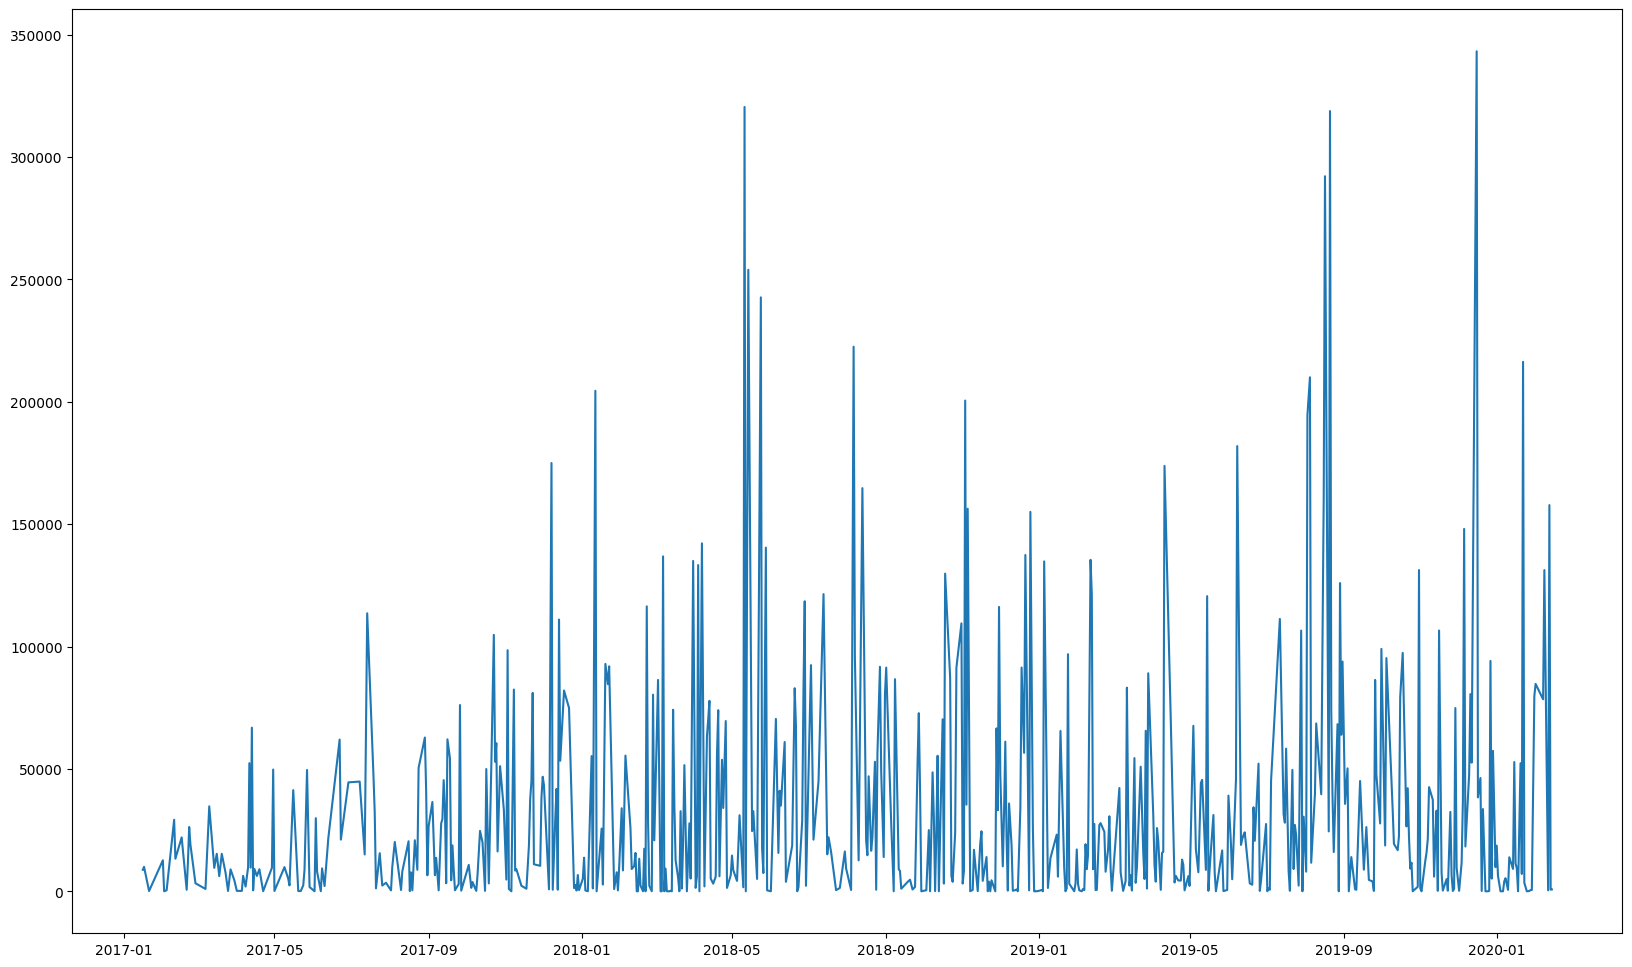

In [186]:
plt.figure(figsize=(20, 12))
plt.plot(df2['ds'], df2['y'])
plt.show()

In [187]:
df2['y'] = df2['y'].diff()

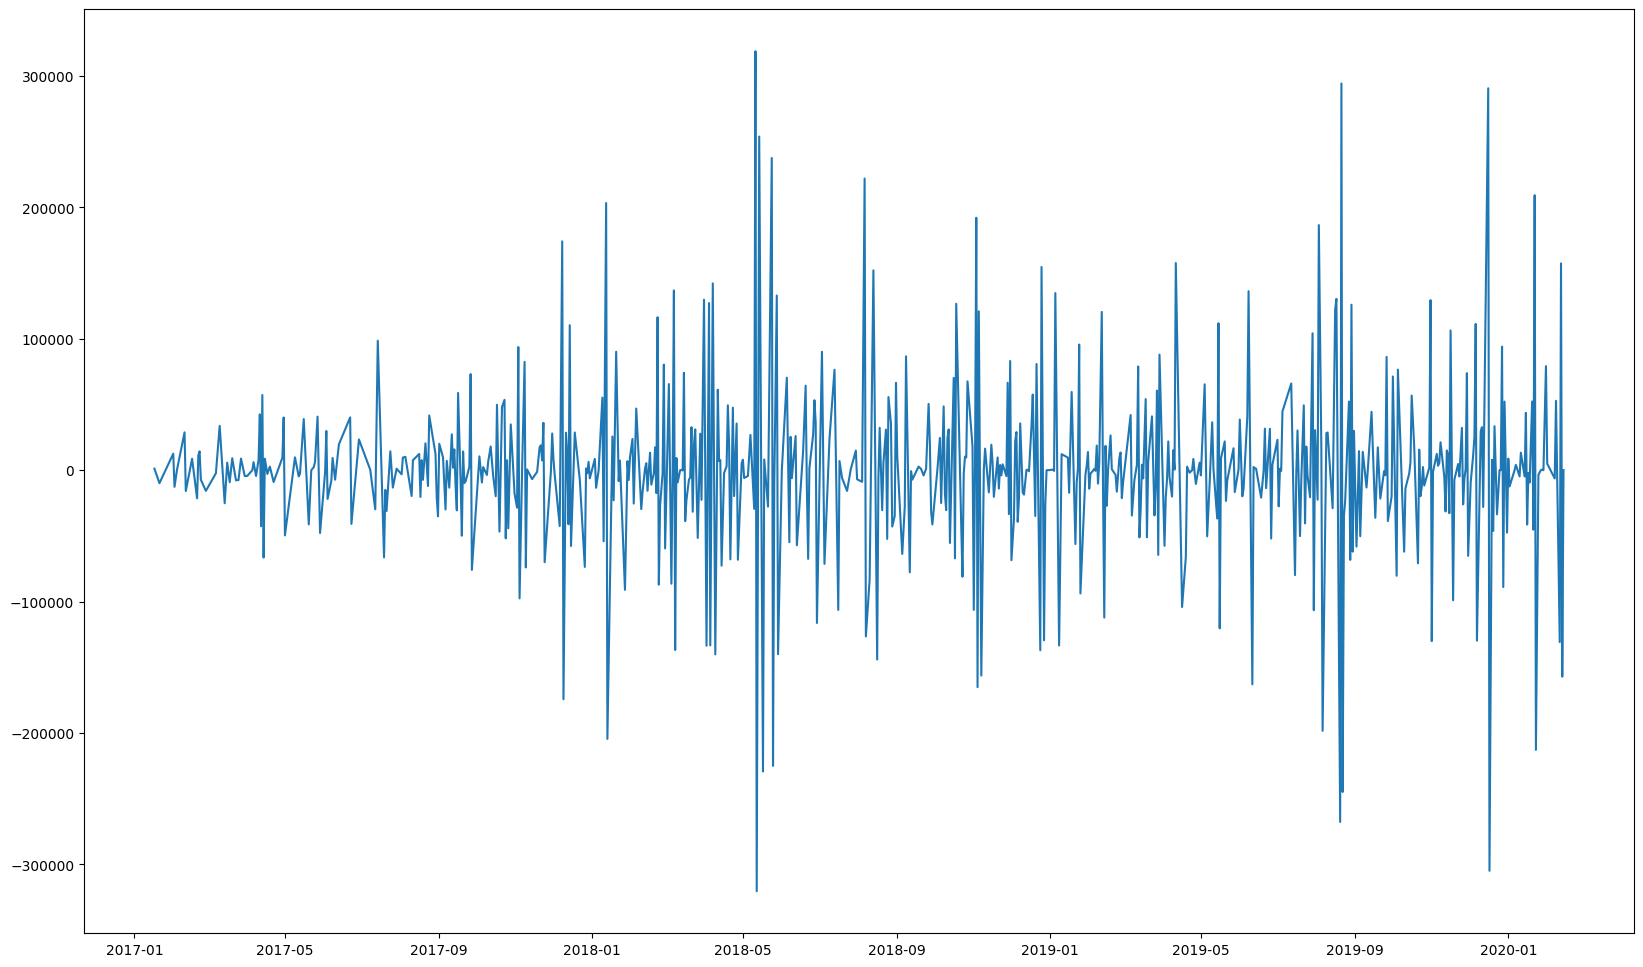

In [188]:
plt.figure(figsize=(20, 12))
plt.plot(df2['ds'], df2['y'])
plt.show()

In [189]:
df2 = df2.drop(df2.index[0])
adfuller(df2['y'])

(-13.825029500482612,
 7.778032473140839e-26,
 8,
 607,
 {'1%': -3.441169060335662,
  '5%': -2.866313284942438,
  '10%': -2.56931205548122},
 14581.112179731583)

In [190]:
df2['y'] = df2['y'].diff(4)
df2

,ds,y
1,2017-01-17,NaN
2,2017-01-21,NaN
3,2017-02-01,NaN
4,2017-02-02,NaN
5,2017-02-04,-803.0250
...,...,...
615,2020-02-08,52773.2500
616,2020-02-11,-210022.0825
617,2020-02-12,152396.4825
618,2020-02-13,-150814.0500


In [191]:
df2 = df2.drop([1, 2, 3, 4], axis=0)
adfuller(df2['y'])

(-10.07738397333225,
 1.2136752971958153e-17,
 19,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 14626.940793366448)

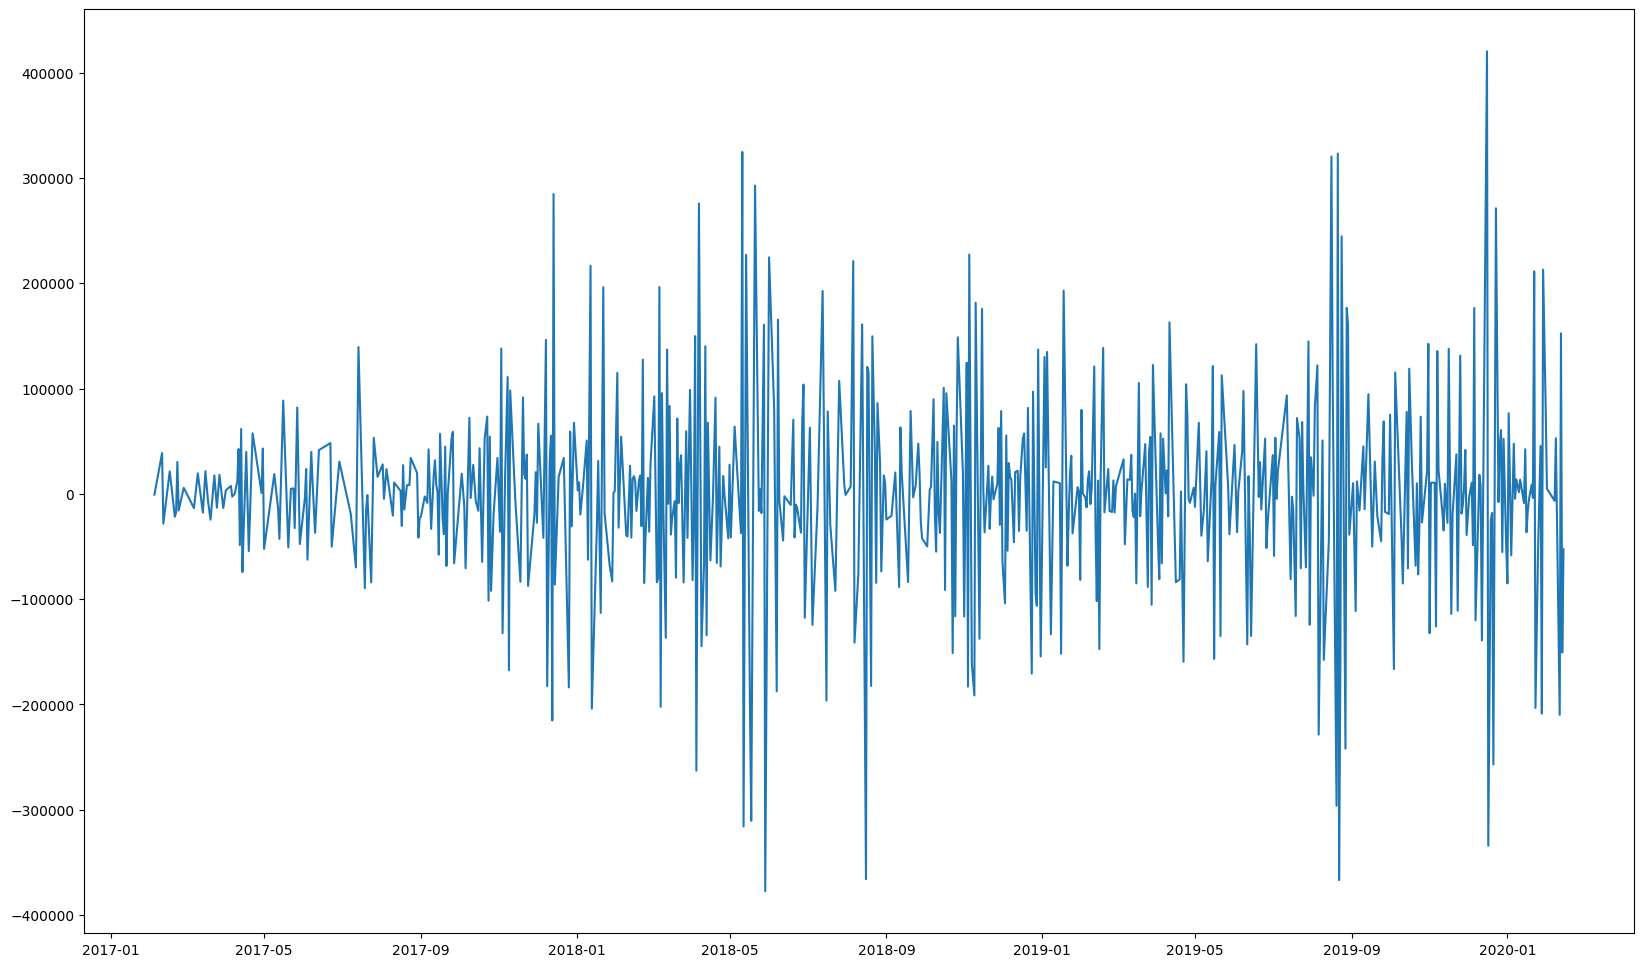

In [192]:
plt.figure(figsize=(20, 12))
plt.plot(df2['ds'], df2['y'])
plt.show()


In [193]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [194]:


df3 = pd.read_excel("order,time series.xlsx")

In [195]:
import pandas as pd
df.rename(columns={'Custorderdate': 'Date'}, inplace=True)
columns_to_keep = ['Date', 'Amount']
df3 = df[columns_to_keep]

# Convert 'Custorderdate' column to datetime format
df3['Date'] = pd.to_datetime(df3['Date'])

# Group by 'Custorderdate' and sum the 'Amount' for each date
df3 = df.groupby('Date')['Amount'].sum().reset_index()
df3= df3.rename(columns={'Date': 'ds','Amount': 'y',})

df3 = df3[['ds', 'y']]

# Find the index of the outlier (for example, the maximum value in 'y')
outlier_index = df3['y'].idxmax()


outlier_indices = df3['y'].nlargest(3).index

# Drop the rows corresponding to the outlier indices
df3 = df3.drop(outlier_indices)


In [196]:

#import statsmodels.api as sm
model = SARIMAX(df3['y'], order=(0, 1, 1), seasonal_order=(1, 1, [], 12))
res = model.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  617
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -7519.381
Date:                             Tue, 05 Dec 2023   AIC                          15044.762
Time:                                     10:45:14   BIC                          15057.973
Sample:                                          0   HQIC                         15049.904
                                             - 617                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9971      0.017    -58.716      0.000      -1.030      -0.964
ar.S.L12      -0.5122      0.036    -14.122      0.000      -0.583      -0.441
sigma2      5.562e+09   3.07e-13   1.81e+22      0.000    5.56e+09    5.56e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               732.60
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.7e+37. Standard errors may be unstable.
"""

In [197]:
df3['sarimax'] = res.fittedvalues
df3



,ds,y,sarimax
0,2017-01-16,8780.6250,0.000000
1,2017-01-17,9982.7500,4390.914906
2,2017-01-21,102.5000,6255.381882
3,2017-02-01,12666.4375,4716.348984
4,2017-02-02,9.5000,6307.757860
...,...,...,...
615,2020-02-08,131229.1000,10023.757622
616,2020-02-11,389.0250,29584.111679
617,2020-02-12,157779.4000,4189.802350
618,2020-02-13,659.0000,106741.542667


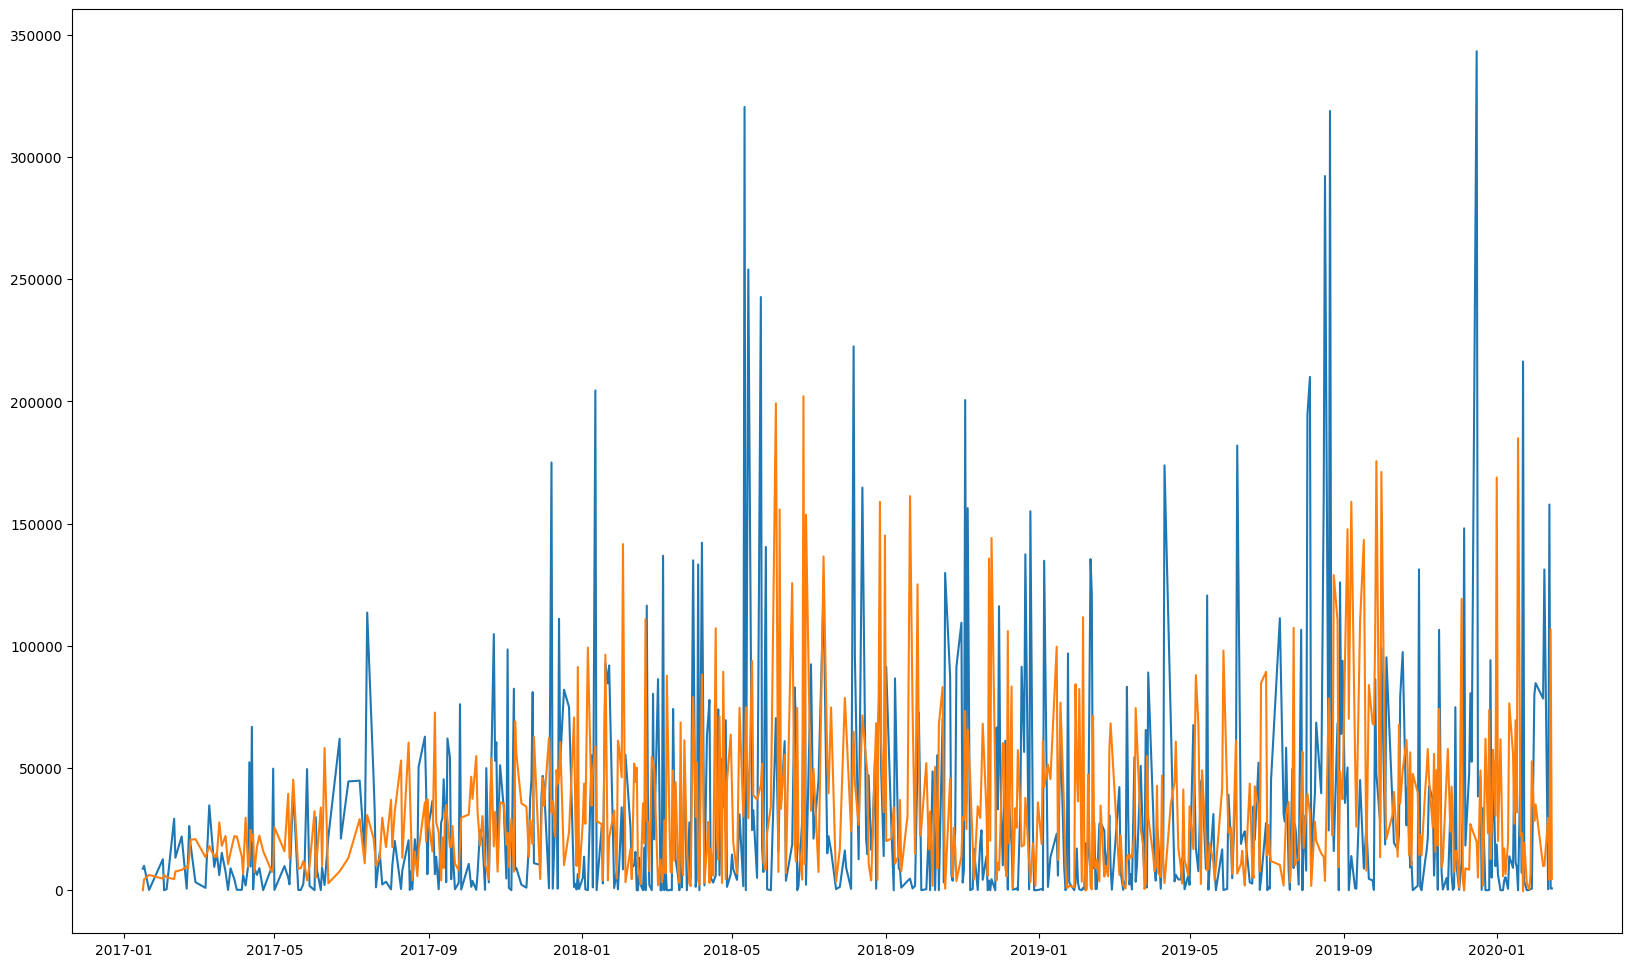

In [198]:
plt.figure(figsize=(20, 12))
plt.plot(df3['ds'], df3['y'])
plt.plot(df3['ds'], df3['sarimax'])
plt.show()

In [199]:
pred['sarimax'] = df3['sarimax']

pred

,ds,mean_baseline,naive_baseline,seasonal_naive_baseline,drift_baseline,Prophet,autoarima,sarimax
0,2017-01-16,32474.388115,389.025,7071.50,375.402273,54244.235267,41841.444651,0.000000
1,2017-01-17,32474.388115,389.025,216316.95,361.779545,43325.256327,46114.551493,4390.914906
2,2017-01-21,32474.388115,389.025,3481.50,348.156818,39158.499748,35538.041309,6255.381882
3,2017-02-01,32474.388115,389.025,0.00,334.534091,43246.509935,48266.131357,4716.348984
4,2017-02-02,32474.388115,389.025,112.72,320.911364,50384.971580,35125.407701,6307.757860
...,...,...,...,...,...,...,...,...
615,2020-02-08,32474.388115,389.025,NaN,NaN,NaN,NaN,10023.757622
616,2020-02-11,32474.388115,389.025,NaN,NaN,NaN,NaN,29584.111679
617,2020-02-12,32474.388115,389.025,NaN,NaN,NaN,NaN,4189.802350
618,2020-02-13,32474.388115,389.025,NaN,NaN,NaN,NaN,106741.542667


In [200]:
df3['sarimax'][:5] = np.NaN
forecast = res.predict(start=len(df3), end=len(df3) + 8)
len(pred)


620

In [201]:
len(forecast)

9

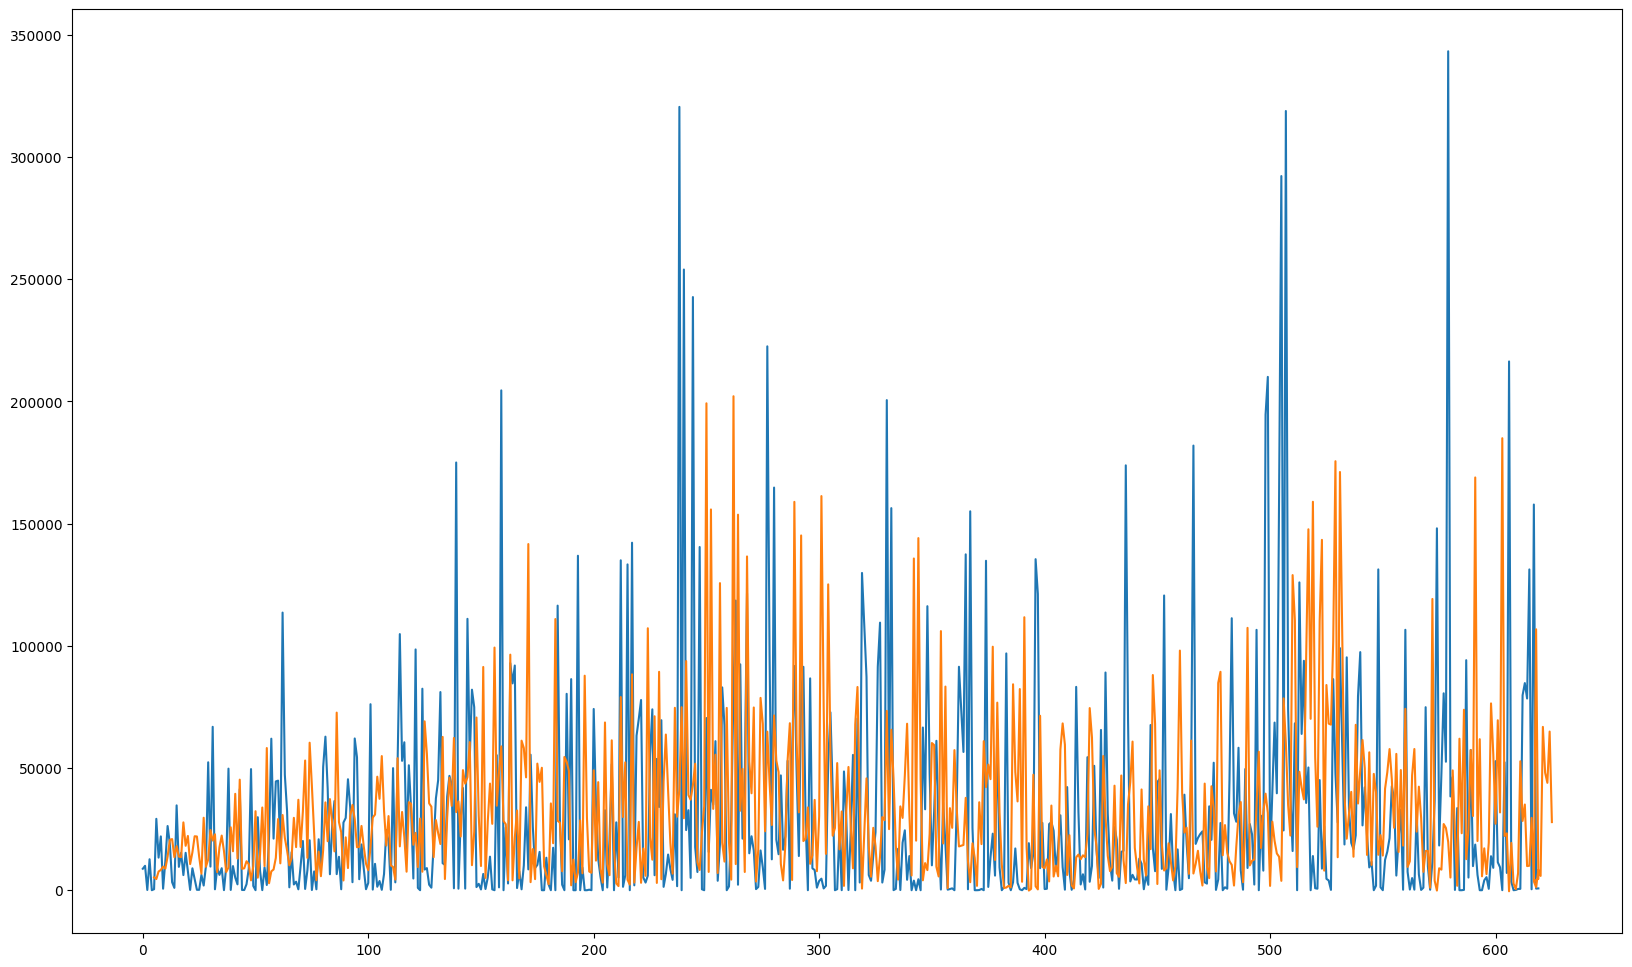

In [202]:
forecast = df3['sarimax'].append(forecast)
plt.figure(figsize=(20, 12))
plt.plot(df3['y'])
plt.plot(forecast)
plt.show()

In [203]:
from itertools import product
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
ps = range(0, 2, 1)
ds = 1
qs = range(0, 2, 1)
s = 12
params = list(product(p, q, ps, qs))
params

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]

In [204]:
results = []
for order in params:
    try:
        model = sm.tsa.statespace.SARIMAX(df3['y'], order=(order[0], d, order[1]), seasonal_order=(order[1], ds, order[3], s))
        res = model.fit()
        results.append([order, res.aic])
    except:
        continue
        
        
       

In [205]:
print(results)

[[(0, 0, 0, 0), 15539.5602456175], [(0, 0, 0, 1), 15230.913806511362], [(0, 0, 1, 0), 15539.5602456175], [(0, 0, 1, 1), 15230.913806508412], [(0, 1, 0, 0), 15044.762374494101], [(0, 1, 0, 1), 14947.39709177745], [(0, 1, 1, 0), 15044.762374684502], [(0, 1, 1, 1), 14947.397091807146], [(1, 0, 0, 0), 15314.284644384043], [(1, 0, 0, 1), 15041.886252370106], [(1, 0, 1, 0), 15314.284644384043], [(1, 0, 1, 1), 15041.886252370237], [(1, 1, 0, 0), 15041.039981218262], [(1, 1, 0, 1), 14940.632896118896], [(1, 1, 1, 0), 15041.03998145198], [(1, 1, 1, 1), 14940.632890224708]]


In [206]:
r = pd.DataFrame(results)
r.columns = ('order', 'AIC')
r.sort_values(by='AIC', ascending=True)

,order,AIC
15,"(1, 1, 1, 1)",14940.632890
13,"(1, 1, 0, 1)",14940.632896
5,"(0, 1, 0, 1)",14947.397092
7,"(0, 1, 1, 1)",14947.397092
12,"(1, 1, 0, 0)",15041.039981
14,"(1, 1, 1, 0)",15041.039981
9,"(1, 0, 0, 1)",15041.886252
11,"(1, 0, 1, 1)",15041.886252
4,"(0, 1, 0, 0)",15044.762374
6,"(0, 1, 1, 0)",15044.762375


In [207]:
model = SARIMAX(df3['y'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  617
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7469.699
Date:                            Tue, 05 Dec 2023   AIC                          14947.397
Time:                                    10:45:41   BIC                          14965.011
Sample:                                         0   HQIC                         14954.252
                                            - 617                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9532      0.023    -41.300      0.000      -0.998      -0.908
ar.S.L12      -0.0593      0.121     -0.492      0.622      -0.296       0.177
ma.S.L12      -0.9287      0.061    -15.228      0.000      -1.048      -0.809
sigma2      5.562e+09   8.71e-12   6.39e+20      0.000    5.56e+09    5.56e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              2505.18
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.67   Skew:                             2.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+36. Standard errors may be unstable.
"""

In [208]:
df3['sarimax'][:5] = np.NaN
forecast = res.predict(start=len(df3), end=len(df3) + 8)

In [209]:
forecast = df3['sarimax'].append(forecast)

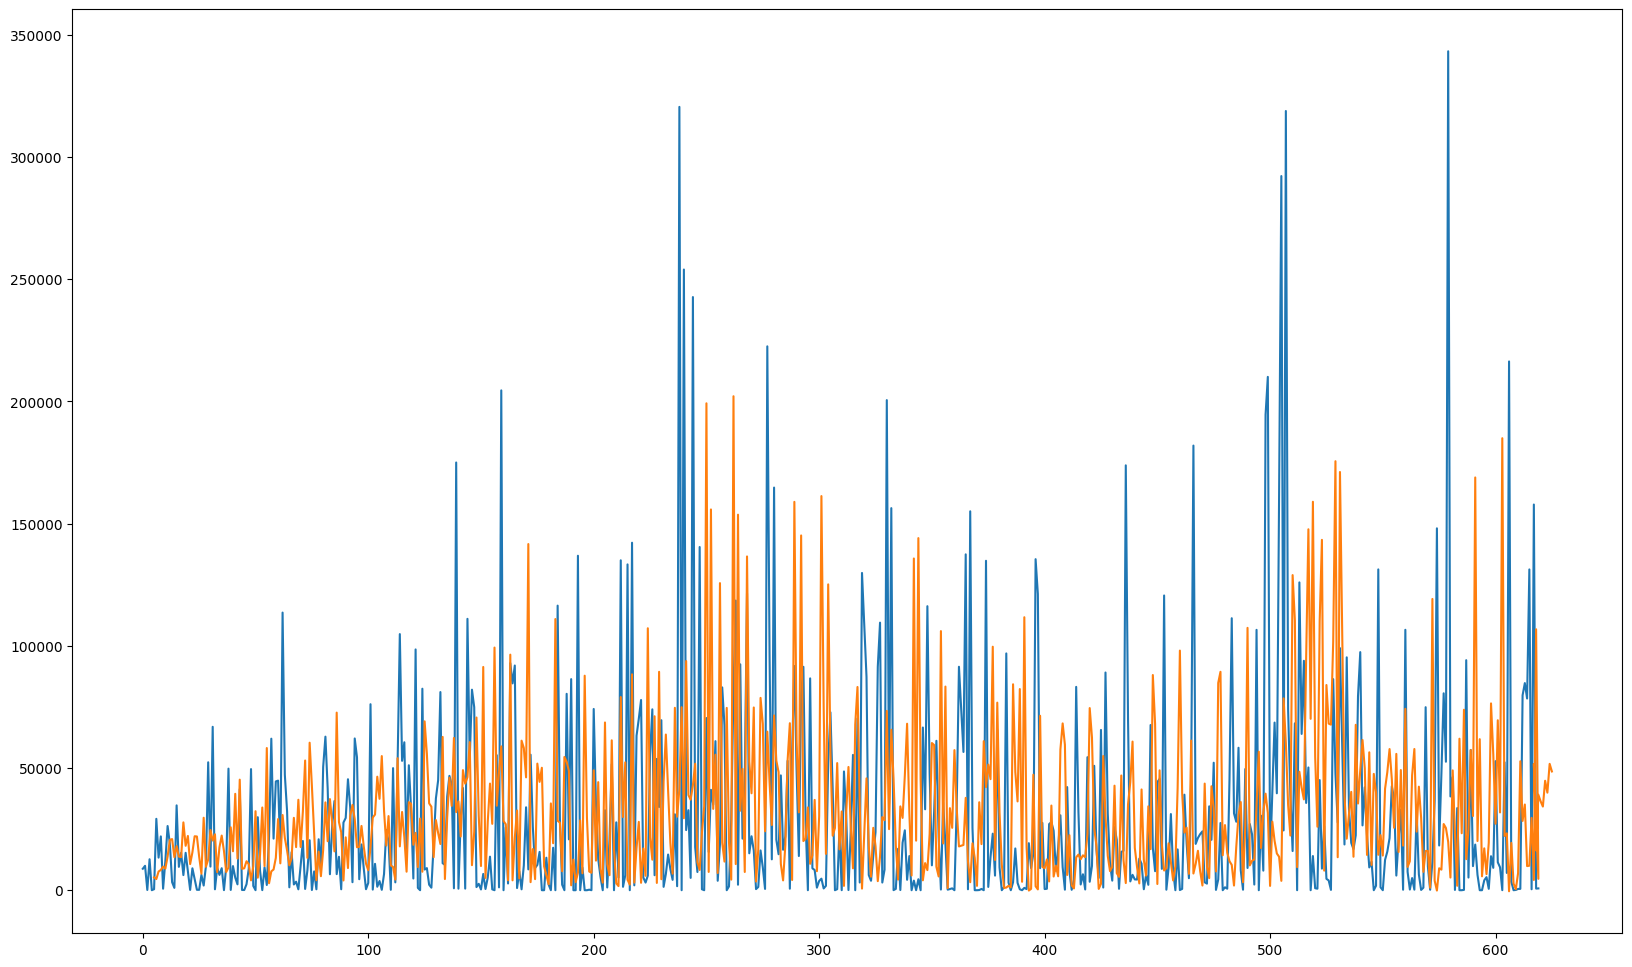

In [210]:
plt.figure(figsize=(20, 12))
plt.plot(df3['y'])
plt.plot(forecast)
plt.show()

## Comparison

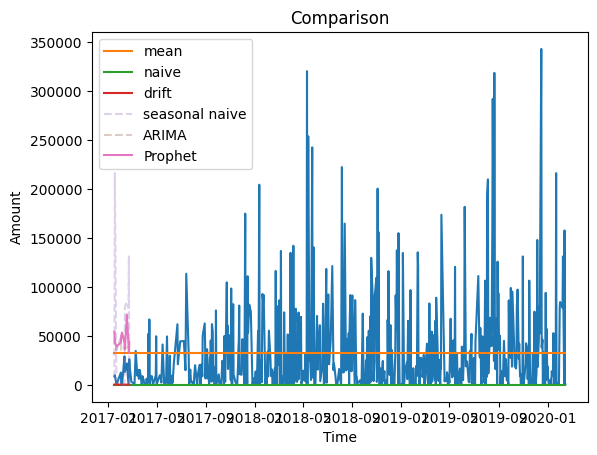

In [212]:

plt.plot(df1_train['ds'], df1_train['y'])
plt.plot(pred['ds'], pred['mean_baseline'], label = 'mean')
plt.plot(pred['ds'], pred['naive_baseline'], label = 'naive')
plt.plot(pred['ds'], pred['drift_baseline'], label = 'drift')
plt.plot(pred['ds'], pred['seasonal_naive_baseline'], label = 'seasonal naive', linestyle = '--', alpha = 0.3)
plt.plot(pred['ds'], pred['autoarima'], label = 'ARIMA', linestyle = '--', alpha = 0.3)
plt.plot(pred['ds'], pred['Prophet'], label = 'Prophet')
#plt.plot(pred['ds'], pred['regression'], label = 'regression')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Comparison')
plt.legend()
plt.show()


In [227]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming 'pred' and 'df1_test' are DataFrames with a common column 'ds'

# Merge the DataFrames based on the 'ds' column
merged_data = pd.merge(pred, df1_test, on='ds', how='inner')

# Drop rows containing NaN values in the columns used for MSE calculation
merged_data_clean = merged_data.dropna(subset=['mean_baseline', 'naive_baseline', 'seasonal_naive_baseline', 'drift_baseline', 'autoarima', 'Prophet', 'y'])

# Calculate MSE for relevant columns of different models after dropping NaN values
print('Mean baseline MSE: ', mean_squared_error(merged_data_clean['mean_baseline'], merged_data_clean['y']))
print('Naive baseline MSE: ', mean_squared_error(merged_data_clean['naive_baseline'], merged_data_clean['y']))
print('Seasonal naive baseline MSE : ', mean_squared_error(merged_data_clean['seasonal_naive_baseline'], merged_data_clean['y']))
print('Drift baseline MSE: ', mean_squared_error(merged_data_clean['drift_baseline'], merged_data_clean['y']))
print('Auto Arima Model MSE:', mean_squared_error(merged_data_clean['autoarima'], merged_data_clean['y']))
print('Prophet Model MSE:', mean_squared_error(merged_data_clean['Prophet'], merged_data_clean['y']))
# Add other models in a similar manner


Mean baseline MSE:  546121521.2793223
Naive baseline MSE:  215082799.67359272
Seasonal naive baseline MSE :  6072979563.440098
Drift baseline MSE:  217393431.58410922
Auto Arima Model MSE: 883218594.994877
Prophet Model MSE: 1375473328.2998636


## Prediction

In [217]:
m = Prophet()
m.fit(df1)
future2 = m.make_future_dataframe(periods =12, freq ="MS",include_history=False )
forecast = m.predict(future2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(12)




10:48:40 - cmdstanpy - INFO - Chain [1] start processing
10:48:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2020-03-01,12000.182973,-531115.869761,553716.137461
1,2020-04-01,-18000.278542,-555049.465139,501060.121734
2,2020-05-01,-34891.430260,-554224.810425,496931.665898
3,2020-06-01,-13729.362632,-556910.209357,506415.023810
4,2020-07-01,15711.024112,-497658.062029,548416.304423
5,2020-08-01,104289.900518,-449151.846839,629695.159132
6,2020-09-01,-5319.232442,-500240.922322,510367.756286
7,2020-10-01,-38718.610842,-553138.276096,489390.117565
8,2020-11-01,107356.920277,-394561.692529,647496.797127
9,2020-12-01,-7660.998388,-533945.983344,526428.612040


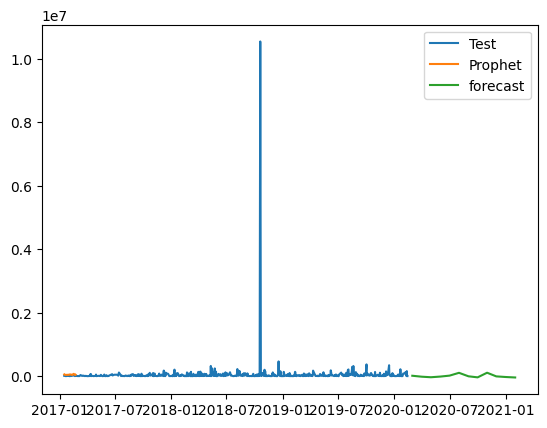

In [218]:
plt.plot(df1['ds'], df1['y'],label = 'Test')
plt.plot(pred['ds'], pred['Prophet'], label = 'Prophet')
# plt.plot(pred['ds'], pred['mean_baseline'], label = 'mean')
plt.plot(forecast['ds'], forecast['yhat'], label = 'forecast')
plt.legend()
plt.show()